# Fake News Project
The goal of this project is to create a fake news prediction system. Fake news is a major problem that can have serious negative effects on how people understand the world around them. You will work with a dataset containing real and fake news in order to train a simple and a more advanced classifier to solve this problem. This project covers the full Data Science pipeline, from data processing, to modelling, to visualization and interpretation.
## Part 1 Data Processing

### Task 1

In [19]:
import pandas as pd 
df = pd.read_csv("news_sample.csv")
dfcpy = df.copy()
dfcpy = dfcpy.dropna(subset=['content'])

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

In [20]:
import re
import nltk
from nltk.tokenize.regexp import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.probability import FreqDist
from cleantext import clean


def clean_text(text):
  clean_text = re.sub(r'([A-Z][A-z]+.?) ([0-9]{1,2}?), ([0-9]{4})', '<DATE>', text)
  clean_text = clean(clean_text,
    lower=True,
    no_urls=True, replace_with_url="<URL>",
    no_emails=True, replace_with_email="<EMAIL>",
    no_numbers=True, replace_with_number= r"<NUM>",
    no_currency_symbols=True, replace_with_currency_symbol="<CUR>",
    no_punct=True, replace_with_punct="",
    no_line_breaks=True 
  )
  return clean_text

def rmv_stopwords(tokens):
  stop_words = set(nltk.corpus.stopwords.words('english'))
  tokens = [word for word in tokens if word not in stop_words]
  return tokens

def stem_tokens(tokens):
  stemmer=PorterStemmer()
  Output=[stemmer.stem(word) for word in tokens]
  return Output

# build a vocabulary from a dataframe with list of tokens
def build_vocabulary(df_tokens):
    # Flatten the list of tokens
  tokens = []
  for lst in df_tokens:
    tokens += lst
  fq = FreqDist(tokens)
  return fq

In [21]:
dfcpy = df.copy()

dfcpy.content = dfcpy.content.apply(clean_text)

tokenizer = RegexpTokenizer(r'<[\w]+>|[\w]+')
dfcpy["tokenized"] = dfcpy.content.apply(tokenizer.tokenize)

vocab = build_vocabulary(dfcpy.tokenized)
vocab_size = vocab.B()
print("After cleaning:")
print(f"vocabulary size: {vocab_size}\n")

dfcpy.tokenized = dfcpy.tokenized.apply(rmv_stopwords)
vocab = build_vocabulary(dfcpy.tokenized)
# reduction rate of the vocabulary size
reduction = ((vocab_size - vocab.B())/vocab_size)*100
vocab_size = vocab.B()
print("After removing stopwords:")
print(f"vocabulary size: {vocab_size}")
print(f"reduction rate of the vocabulary size: {reduction:.2f}%\n")

dfcpy.tokenized = dfcpy.tokenized.apply(stem_tokens)
vocab = build_vocabulary(dfcpy.tokenized)
reduction = ((vocab_size - vocab.B())/vocab_size)*100
vocab_size = vocab.B()
print("After stemming:")
print(f"vocabulary size: {vocab_size}")
print(f"reduction rate of the vocabulary size: {reduction:.2f}%\n")

After cleaning:
vocabulary size: 16577

After removing stopwords:
vocabulary size: 16445
reduction rate of the vocabulary size: 0.80%

After stemming:
vocabulary size: 11031
reduction rate of the vocabulary size: 32.92%




1. counting the number of URLs in the content
2. counting the number of dates in the content
3. counting the number of numeric values in the content
4. determining the 100 more frequent words that appear in the content
5. plot the frequency of the 10000 most frequent words (any interesting patterns?)
6. run the analysis in point 4 and 5 both before and after removing stopwords and applying stemming: do you see any difference?


In [42]:
import pandas as pd 

df = pd.read_csv("995,000_rows.csv", usecols=['content', 'type', 'url', 'title', 'authors', 'domain'], engine='c', dtype = str, nrows=70000)
dfcpy = df.copy()
dfcpy = dfcpy.dropna(subset=['content'])
dfcpy = dfcpy.dropna(subset=['type'])

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
# plot the frequency of the top n words
def plot_freq(fq, top_n):
  common_words = fq.most_common(top_n)
  # convert the list of tuples to a dictionary 
  all_freq = dict(common_words)
  # create a plot
  # plot most be less than 2^16 pixels in each direction
  plt.figure(figsize = (top_n*0.1, 5))
  plt.xticks(rotation = 90,fontsize = 5)
  plt.yticks(range(0, max(all_freq.values())+1, 300))
  sns.lineplot(x = list(all_freq.keys()), y = list(all_freq.values()), color = 'red')
  sns.barplot(x = list(all_freq.keys()), y = list(all_freq.values()))
  plt.title(f'Top {top_n} most common words')
  plt.xlabel('Words')
  plt.ylabel('Frequency')
  plt.grid(axis = 'y')
  plt.show()
  return

In [44]:
dfcpy.content = dfcpy.content.apply(clean_text)

In [45]:
tokenizer = RegexpTokenizer(r'<[\w]+>|[\w]+')
dfcpy["tokenized"] = dfcpy.content.apply(tokenizer.tokenize)


In [46]:
dfcpy.tokenized = dfcpy.tokenized.apply(rmv_stopwords)

In [47]:
dfcpy.tokenized = dfcpy.tokenized.apply(stem_tokens)

In [48]:
vocab = build_vocabulary(dfcpy.tokenized)

## Data exploration

Number of URLs in the content: 21858
Number of dates in the content: 27394
Number of numerics in the content: 531649


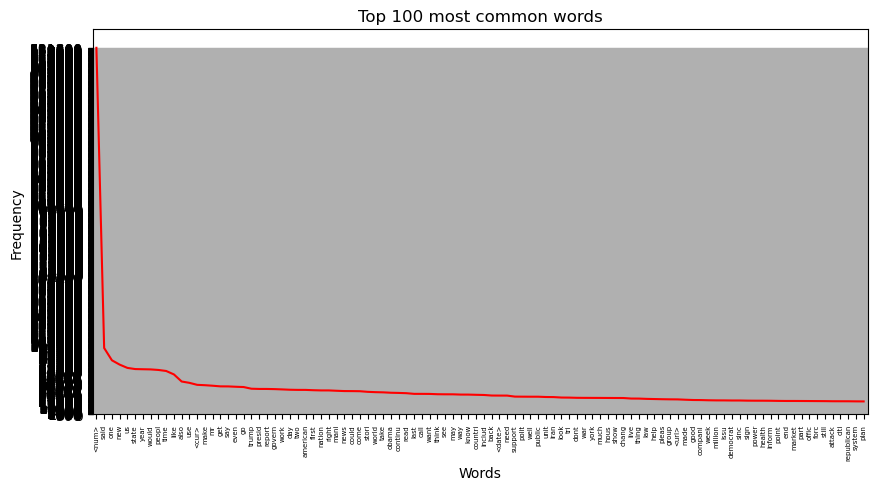

In [49]:
# make tokenize colum into a string with whitespace separator
dfcpy.tokenized = dfcpy.tokenized.apply(lambda x: ' '.join(x))
url_freq = vocab.get("<url>",0)
date_freq = vocab.get("<date>",0)
num_freq = vocab.get("<num>",0)
print(f"Number of URLs in the content: {url_freq}")
print(f"Number of dates in the content: {date_freq}")
print(f"Number of numerics in the content: {num_freq}")
plot_freq(vocab, 100)

dfcpy.to_csv('cleaned_news_sample.csv', index=False)

# Task 4

Training Set:
32027    plu one articl googl plu thank ali alfoneh ass...
9249     republican vote suppress reach new level cun d...
18377    editor note move explor world futur person tra...
50780    five men charg feder district court brooklyn y...
7843     aspen santa fe ballet two home hous choreograp...
Name: tokenized, dtype: object


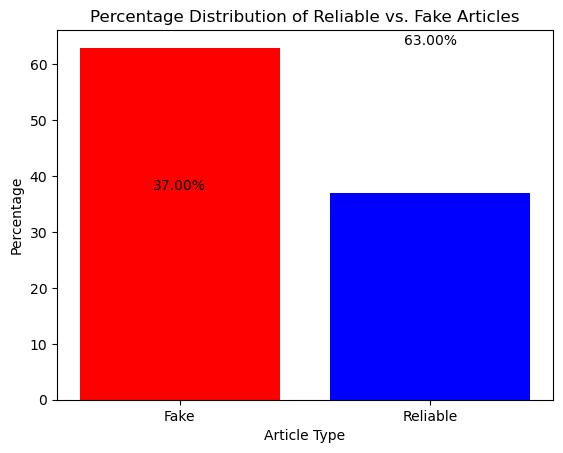

In [50]:
from sklearn.model_selection import train_test_split

df = pd.read_csv('cleaned_news_sample.csv')
dfcpy = df.copy()


# label is 1 if the article is fake, 0 if the article is reliable
dfcpy['label'] = dfcpy['type'].map({'fake': 1, 'conspiracy': 1, 'junksci': 1, 'clickbait': 0, 'political': 0, 'reliable': 0})
dfcpy = dfcpy.dropna(subset=['label'])
dfcpy['label'] = dfcpy['label'].astype(int)

X = dfcpy['tokenized']

y = dfcpy['label']

train_ratio = 0.80
validation_ratio = 0.10
test_ratio = 0.10

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 1 - train_ratio, random_state = 42) 
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size= test_ratio / (test_ratio + validation_ratio), random_state = 42)

print("Training Set:")
print(x_train.head())

# Examine the percentage distribution of 'reliable' vs. 'fake' articles
grouped_type = dfcpy['label'].value_counts()
grouped_type = grouped_type / grouped_type.sum() * 100

# make a bar plot with percentages on bars
plt.bar([0, 1], grouped_type, tick_label=['Fake', 'Reliable'], color=['red', 'blue'])
plt.text(0, grouped_type[1], f'{grouped_type[1]:.2f}%', ha='center', va='bottom')
plt.text(1, grouped_type[0], f'{grouped_type[0]:.2f}%', ha='center', va='bottom')
plt.xlabel('Article Type')
plt.ylabel('Percentage')
plt.title('Percentage Distribution of Reliable vs. Fake Articles')
plt.show()



# Part 2: A simple model

Accuracy: 0.8949762249328096
Recall: 0.8067039106145252
Precision: 0.8991282689912827
F1: 0.850412249705536
              precision    recall  f1-score   support

        fake       0.89      0.95      0.92      3047
        real       0.90      0.81      0.85      1790

    accuracy                           0.89      4837
   macro avg       0.90      0.88      0.88      4837
weighted avg       0.90      0.89      0.89      4837



/home/katikistan/miniconda3/envs/my_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


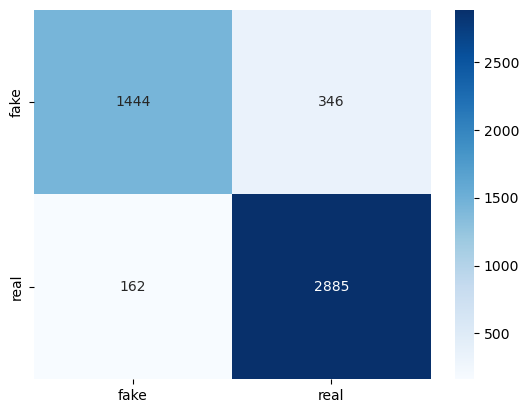

In [51]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler

# scaling the data
scaler = StandardScaler(with_mean=False)

vectorizer = TfidfVectorizer()
X_train_vectorized = vectorizer.fit_transform(x_train)
X_test_vectorized = vectorizer.transform(x_test)
x_val_vectorized = vectorizer.transform(x_val)

model = LogisticRegression(random_state=42, max_iter=10000)
model.fit(X_train_vectorized, y_train)
y_pred = model.predict(x_val_vectorized)

# scoring the model
accuracy_score = metrics.accuracy_score(y_val, y_pred)
recall_score = metrics.recall_score(y_val, y_pred, average='binary', zero_division=0, pos_label=1)
precision_score = metrics.precision_score(y_val, y_pred, average='binary', zero_division=0, pos_label=1)
f1_score = metrics.f1_score(y_val, y_pred, average='binary', zero_division=0, pos_label=1)

print(f"Accuracy: {accuracy_score}")
print(f"Recall: {recall_score}")
print(f"Precision: {precision_score}")  
print(f"F1: {f1_score}")

# confusion matrix
confusion_matrix = metrics.confusion_matrix(y_val, y_pred, labels=[1, 0])
sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=['fake', 'real'], yticklabels=['fake', 'real'])

# classification report
classification_report = metrics.classification_report(y_val, y_pred, target_names = ['fake', 'real'], zero_division=0)
print(classification_report)


# Part 3: Advanced model

4 models: 
- SGD
- SVM
- LinearSVM
- Nerual network

2 vector representations:
- TF-IDF
- Word embedding

We perfrom cross validation on hyper paramaters to find the best hyperparameters for each model 

// make table comparing scores for each model  

TFID vectorizer

In [52]:
from sklearn.preprocessing import StandardScaler
# more complex data representation
vectorizer = TfidfVectorizer(use_idf=True, smooth_idf=True, norm='l2')
X_train_vectorized = vectorizer.fit_transform(x_train)
X_test_vectorized = vectorizer.transform(x_test)
x_val_vectorized = vectorizer.transform(x_val)

# scaling the data
scaler = StandardScaler(with_mean=False)
X_train_vectorized_scaled = scaler.fit_transform(X_train_vectorized)

Word embedding

In [53]:
# use word embeddings on the training data
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import numpy as np

# train the word2vec model
model = Word2Vec(x_train, vector_size=100, window=5, min_count=1, workers=4)

# function to average the word vectors for each article
def average_word_vectors(words, model, vocabulary, num_features):
    feature_vector = np.zeros((num_features,), dtype="float64")
    nwords = 0.
    
    for word in words:
        if word in vocabulary: 
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model.wv[word])
    
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
        
    return feature_vector

# function to calculate the average word vectors for each article
def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index_to_key)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)

# get the average word vectors for each article
X_train_word_average = averaged_word_vectorizer(corpus=x_train, model=model, num_features=100)
X_val_word_average = averaged_word_vectorizer(corpus=x_val, model=model, num_features=100)


## Model 1: Stochastic Gradient Descent

In [54]:
# linear model
import sklearn.linear_model as lm
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

model_sgdc = lm.SGDClassifier(random_state=42, max_iter=1000)
make_pipeline(StandardScaler(), lm.SGDClassifier())


# parameters we want to test for the lm model
losses = list(['hinge', 'squared_hinge', 'perceptron', 'squared_error', 'huber', 'epsilon_insensitive'])
penalties = list(['l1', 'l2', 'elasticnet'])
alphas = list([0.1, 1, 10, 100, 1000])
l1_ratios = list([0.1, 0.3, 0.5, 0.7, 0.9])
param_grid_lm = dict(loss=losses,penalty=penalties, alpha=alphas, l1_ratio=l1_ratios)


# search for the best parameters
grid_lm = GridSearchCV(model_sgdc, param_grid_lm, cv=2, n_jobs=-1, scoring='accuracy')
grid_lm.fit(cp.asarray(X_train_vectorized_scaled), cp.asarray(y_train))

print(f"Best parameters for the linear model: {grid_lm.best_params_}")

lm_using_best_params = lm.SGDClassifier(random_state=42, loss=grid_lm.best_params_['loss'], penalty=grid_lm.best_params_['penalty'], alpha=grid_lm.best_params_['alpha'], l1_ratio=grid_lm.best_params_['l1_ratio'])
lm_using_best_params.fit(cp.asarray(X_train_vectorized_scaled), cp.asarray(y_train))
y_pred = lm_using_best_para# linear model
import sklearn.linear_model as lm
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

model_sgdc = lm.SGDClassifier(random_state=42, max_iter=1000)
make_pipeline(StandardScaler(), lm.SGDClassifier())


# parameters we want to test for the lm model
losses = list(['hinge', 'squared_hinge', 'perceptron', 'squared_error', 'huber', 'epsilon_insensitive'])
penalties = list(['l1', 'l2', 'elasticnet'])
alphas = list([0.1, 1, 10, 100, 1000])
l1_ratios = list([0.1, 0.3, 0.5, 0.7, 0.9])
param_grid_lm = dict(loss=losses,penalty=penalties, alpha=alphas, l1_ratio=l1_ratios)


# search for the best parameters
grid_lm = GridSearchCV(model_sgdc, param_grid_lm, cv=2, n_jobs=-1, scoring='accuracy')
grid_lm.fit(cp.asarray(X_train_vectorized_scaled), cp.asarray(y_train))

print(f"Best parameters for the linear model: {grid_lm.best_params_}")

lm_using_best_params = lm.SGDClassifier(random_state=42, loss=grid_lm.best_params_['loss'], penalty=grid_lm.best_params_['penalty'], alpha=grid_lm.best_params_['alpha'], l1_ratio=grid_lm.best_params_['l1_ratio'])
lm_using_best_params.fit(cp.asarray(X_train_vectorized_scaled), cp.asarray(y_train))
y_pred = lm_using_best_params.predict(cp.asarray(x_val_vectorized))

IDF_accuracy_score_lm = metrics.accuracy_score(cp.asnumpy(y_val), cp.asnumpy(y_pred))
IDF_recall_score_lm = metrics.recall_score(cp.asnumpy(y_val), cp.asnumpy(y_pred), average='binary', zero_division=0, pos_label=1)
IDF_precision_score_lm = metrics.precision_score(cp.asnumpy(y_val), cp.asnumpy(y_pred), average='binary', zero_division=0, pos_label=1)
IDF_f1_score_lm = metrics.f1_score(cp.asnumpy(y_val), cp.asnumpy(y_pred), average='binary', zero_division=0, pos_label=1)


print(f"Accuracy: {IDF_accuracy_score_lm}")
print(f"Recall: {IDF_recall_score_lm}")
print(f"Precision: {IDF_precision_score_lm}")
print(f"F1: {IDF_f1_score_lm}")
ms.predict(cp.asarray(x_val_vectorized))

IDF_accuracy_score_lm = metrics.accuracy_score(cp.asnumpy(y_val), cp.asnumpy(y_pred))
IDF_recall_score_lm = metrics.recall_score(cp.asnumpy(y_val), cp.asnumpy(y_pred), average='binary', zero_division=0, pos_label=1)
IDF_precision_score_lm = metrics.precision_score(cp.asnumpy(y_val), cp.asnumpy(y_pred), average='binary', zero_division=0, pos_label=1)
IDF_f1_score_lm = metrics.f1_score(cp.asnumpy(y_val), cp.asnumpy(y_pred), average='binary', zero_division=0, pos_label=1)


print(f"Accuracy: {IDF_accuracy_score_lm}")
print(f"Recall: {IDF_recall_score_lm}")
print(f"Precision: {IDF_precision_score_lm}")
print(f"F1: {IDF_f1_score_lm}")


/home/katikistan/miniconda3/envs/my_env/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/katikistan/miniconda3/envs/my_env/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/katikistan/miniconda3/envs/my_env/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/katikistan/miniconda3/envs/my_env/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing ma

KeyboardInterrupt: 

Word embedding

In [ ]:
# linear model with word embedings
import sklearn.linear_model as lm
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

model_sgdc = lm.SGDClassifier(random_state=42, max_iter=10000)
make_pipeline(StandardScaler(), lm.SGDClassifier())


# parameters we want to test for the lm model
losses = list(['hinge', 'squared_hinge', 'perceptron', 'squared_error', 'huber', 'epsilon_insensitive'])
penalties = list(['l1', 'l2', 'elasticnet'])
alphas = list([0.1, 1, 10, 100, 1000])
l1_ratios = list([0.1, 0.3, 0.5, 0.7, 0.9])
param_grid_lm = dict(loss=losses,penalty=penalties, alpha=alphas, l1_ratio=l1_ratios)


# search for the best parameters
grid_lm = GridSearchCV(model_sgdc, param_grid_lm, cv=2, n_jobs=-1, scoring='accuracy')
grid_lm.fit(X_train_word_average, y_train)

print(f"Best parameters for the linear model: {grid_lm.best_params_}")

lm_using_best_params = lm.SGDClassifier(random_state=42, loss=grid_lm.best_params_['loss'], penalty=grid_lm.best_params_['penalty'], alpha=grid_lm.best_params_['alpha'], l1_ratio=grid_lm.best_params_['l1_ratio'])
lm_using_best_params.fit(X_train_word_average, y_train)
y_pred = lm_using_best_params.predict(X_val_word_average)

WE_accuracy_score_lm = metrics.accuracy_score(y_val, y_pred)
WE_recall_score_lm = metrics.recall_score(y_val, y_pred, average='binary', zero_division=0, pos_label=1)
WE_precision_score_lm = metrics.precision_score(y_val, y_pred, average='binary', zero_division=0, pos_label=1)
WE_f1_score_lm = metrics.f1_score(y_val, y_pred, average='binary', zero_division=0, pos_label=1)


print(f"Accuracy: {WE_accuracy_score_lm}")
print(f"Recall: {WE_recall_score_lm}")
print(f"Precision: {WE_precision_score_lm}")
print(f"F1: {WE_f1_score_lm}")


Best parameters for the linear model: {'alpha': 0.1, 'l1_ratio': 0.1, 'loss': 'hinge', 'penalty': 'l1'}
Accuracy: 0.8181818181818182
Recall: 1.0
Precision: 0.8181818181818182
F1: 0.9


## Model 2: Linear SVC 

In [ ]:
import sklearn.svm as svm
from sklearn.model_selection import GridSearchCV
# make supoprt vector machine model using TF-IDF weighted word vectors, 

model_svm = svm.LinearSVC(dual=True, max_iter=10000, random_state=42)
model_svm.fit(X_train_vectorized_scaled, y_train)

# parameters we want to test for the linear SVC model
penalties = list(['l2'])
losses = list(['hinge', 'squared_hinge'])
tol = list([1e-3, 1e-4])
C = list([1e-5, 1e-4, 1e-3, 0.1, 1, 10, 100, 1000])
param_grid_svm = dict(penalty=penalties, loss=losses, tol=tol, C=C)

grid_svm = GridSearchCV(model_svm, param_grid_svm, cv=2, n_jobs=-1, scoring='accuracy')
grid_svm.fit(X_train_vectorized_scaled, y_train)
print(f"Best parameters for the SVM model: {grid_svm.best_params_}")

svm_using_best_params = svm.LinearSVC(random_state=42,dual=True, max_iter=10000, penalty=grid_svm.best_params_['penalty'], loss=grid_svm.best_params_['loss'], tol=grid_svm.best_params_['tol'], C=grid_svm.best_params_['C'])
svm_using_best_params.fit(X_train_vectorized_scaled, y_train)
y_pred = svm_using_best_params.predict(x_val_vectorized)

IDF_accuracy_score_svm = metrics.accuracy_score(y_val, y_pred)
IDF_recall_score_svm = metrics.recall_score(y_val, y_pred, average='binary', zero_division=0, pos_label=1)
IDF_precision_score_svm = metrics.precision_score(y_val, y_pred, average='binary', zero_division=0, pos_label=1)
IDF_f1_score_svm = metrics.f1_score(y_val, y_pred, average='binary', zero_division=0, pos_label=1)

print(f"Accuracy: {IDF_accuracy_score_svm}")
print(f"Recall: {IDF_recall_score_svm}")
print(f"Precision: {IDF_precision_score_svm}")
print(f"F1: {IDF_f1_score_svm}")

Best parameters for the SVM model: {'C': 0.1, 'loss': 'hinge', 'penalty': 'l2', 'tol': 0.001}
Accuracy: 0.8636363636363636
Recall: 1.0
Precision: 0.8571428571428571
F1: 0.923076923076923


Using word embedding

In [ ]:
import sklearn.svm as svm
from sklearn.model_selection import GridSearchCV
# make supoprt vector machine model using TF-IDF weighted word vectors, 

model_svm = svm.LinearSVC(dual=True, max_iter=10000, random_state=42)
model_svm.fit(X_train_word_average, y_train)

# parameters we want to test for the linear SVC model
penalties = list(['l2'])
losses = list(['hinge', 'squared_hinge'])
tol = list([1e-3, 1e-4])
C = list([0.1, 1, 10, 100, 1000])
param_grid_svm = dict(penalty=penalties, loss=losses, tol=tol, C=C)

grid_svm = GridSearchCV(model_svm, param_grid_svm, cv=2, n_jobs=-1, scoring='accuracy')
grid_svm.fit(X_train_vectorized_scaled, y_train)
print(f"Best parameters for the SVM model: {grid_svm.best_params_}")

svm_using_best_params = svm.LinearSVC(random_state=42,dual=True, max_iter=10000, penalty=grid_svm.best_params_['penalty'], loss=grid_svm.best_params_['loss'], tol=grid_svm.best_params_['tol'], C=grid_svm.best_params_['C'])
svm_using_best_params.fit(X_train_word_average, y_train)
y_pred = svm_using_best_params.predict(X_val_word_average)

WE_accuracy_score_svm = metrics.accuracy_score(y_val, y_pred)
WE_recall_score_svm = metrics.recall_score(y_val, y_pred, average='binary', zero_division=0, pos_label=1)
WE_precision_score_svm = metrics.precision_score(y_val, y_pred, average='binary', zero_division=0, pos_label=1)
WE_f1_score_svm = metrics.f1_score(y_val, y_pred, average='binary', zero_division=0, pos_label=1)

print(f"Accuracy: {WE_accuracy_score_svm}")
print(f"Recall: {WE_recall_score_svm}")
print(f"Precision: {WE_precision_score_svm}")
print(f"F1: {WE_f1_score_svm}")

Best parameters for the SVM model: {'C': 0.1, 'loss': 'hinge', 'penalty': 'l2', 'tol': 0.001}
Accuracy: 0.8181818181818182
Recall: 1.0
Precision: 0.8181818181818182
F1: 0.9


## Model 3: Naive bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB

model_nb = MultinomialNB()
model_nb.fit(X_train_vectorized, y_train)


# parameters we want to test for the naive bayes model
alphas = list([0.1, 1, 10, 100, 1000])
param_grid_nb = dict(alpha=alphas)

grid_nb = GridSearchCV(model_nb, param_grid_nb, cv=2, n_jobs=-1, scoring='accuracy')
grid_nb.fit(X_train_vectorized, y_train)
print(f"Best parameters for the Naive Bayes model: {grid_nb.best_params_}")

nb_using_best_params = MultinomialNB(alpha=grid_nb.best_params_['alpha'])
nb_using_best_params.fit(X_train_vectorized, y_train)
y_pred = nb_using_best_params.predict(x_val_vectorized)

IDF_accuracy_score_nb = metrics.accuracy_score(y_val, y_pred)
IDF_recall_score_nb = metrics.recall_score(y_val, y_pred, average='binary', zero_division=0, pos_label=1)
IDF_precision_score_nb = metrics.precision_score(y_val, y_pred, average='binary', zero_division=0, pos_label=1)
IDF_f1_score_nb = metrics.f1_score(y_val, y_pred, average='binary', zero_division=0, pos_label=1)

print(f"Accuracy: {IDF_accuracy_score_nb}")
print(f"Recall: {IDF_recall_score_nb}")
print(f"Precision: {IDF_precision_score_nb}")
print(f"F1: {IDF_f1_score_nb}")

Best parameters for the Naive Bayes model: {'alpha': 0.1}
Accuracy: 0.8636363636363636
Recall: 1.0
Precision: 0.8571428571428571
F1: 0.923076923076923


Word embbeding 

In [41]:
# from sklearn.naive_bayes import MultinomialNB

# model_nb = MultinomialNB()
# model_nb.fit(X_train_vectorized, y_train)


# # parameters we want to test for the naive bayes model
# alphas = list([0.1, 1, 10, 100, 1000])
# param_grid_nb = dict(alpha=alphas)
# grid_nb = GridSearchCV(model_nb, param_grid_nb, cv=2, n_jobs=-1, scoring='accuracy')
# grid_nb.fit(X_train_word_average, y_train)
# print(f"Best parameters for the Naive Bayes model: {grid_nb.best_params_}")

# nb_using_best_params = MultinomialNB(alpha=grid_nb.best_params_['alpha'])
# nb_using_best_params.fit(X_train_word_average, y_train)
# y_pred = nb_using_best_params.predict(X_val_word_average)

# WE_accuracy_score_nb = metrics.accuracy_score(y_val, y_pred)
# WE_recall_score_nb = metrics.recall_score(y_val, y_pred, average='binary', zero_division=0, pos_label=1)
# WE_precision_score_nb = metrics.precision_score(y_val, y_pred, average='binary', zero_division=0, pos_label=1)
# WE_f1_score_nb = metrics.f1_score(y_val, y_pred, average='binary', zero_division=0, pos_label=1)

# print(f"Accuracy: {WE_accuracy_score_nb}")
# print(f"Recall: {WE_recall_score_nb}")
# print(f"Precision: {WE_precision_score_nb}")
# print(f"F1: {WE_f1_score_nb}")

[[-0.04064347  0.08741001 -0.00884393 ...  0.00354889  0.04169355
   0.04066418]
 [-0.0580855   0.1026221   0.01722655 ...  0.00212081  0.04996724
   0.0402039 ]
 [-0.05286254  0.10294209  0.01584053 ...  0.00993955  0.05775529
   0.05990502]
 ...
 [-0.05856711  0.09595936  0.01989271 ... -0.00106525  0.05132429
   0.04771637]
 [-0.04098183  0.06020191 -0.00456643 ... -0.01111686  0.04567481
   0.03715551]
 [-0.06007648  0.09716175  0.02296475 ...  0.00180644  0.05446563
   0.05129793]]


ValueError: 
All the 10 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/home/katikistan/miniconda3/envs/my_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/katikistan/miniconda3/envs/my_env/lib/python3.11/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/katikistan/miniconda3/envs/my_env/lib/python3.11/site-packages/sklearn/naive_bayes.py", line 772, in fit
    self._count(X, Y)
  File "/home/katikistan/miniconda3/envs/my_env/lib/python3.11/site-packages/sklearn/naive_bayes.py", line 894, in _count
    check_non_negative(X, "MultinomialNB (input X)")
  File "/home/katikistan/miniconda3/envs/my_env/lib/python3.11/site-packages/sklearn/utils/validation.py", line 1490, in check_non_negative
    raise ValueError("Negative values in data passed to %s" % whom)
ValueError: Negative values in data passed to MultinomialNB (input X)


## Model 4: Nerual network